In [11]:
import os
import config
import glob
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from torch.utils.data import DataLoader
import numpy as np
from pathlib import Path

import sys
sys.path.append(config.root_path)
from util import show_dataset_prev

#jupyter nbconvert --to script LaRS_dataset.ipynb

7221 198 198 total: 7617


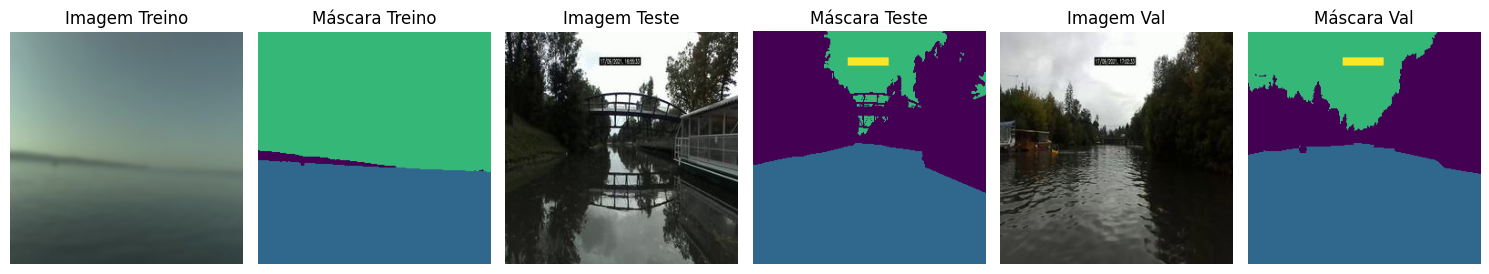

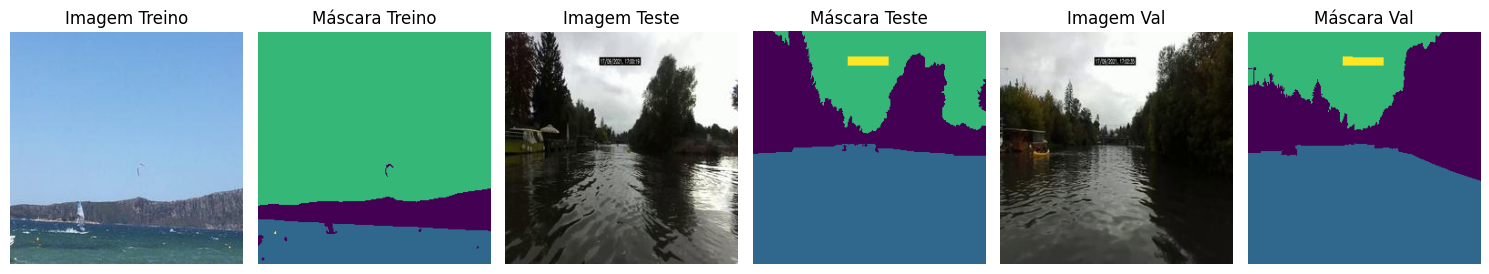

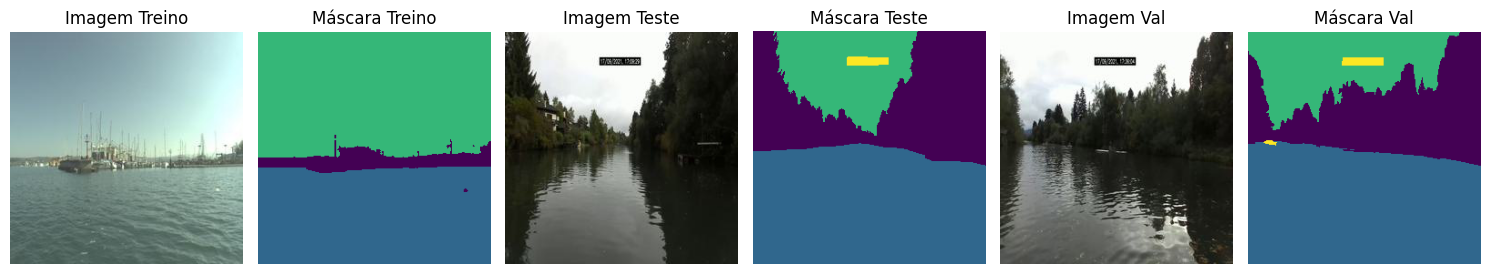

In [13]:


class LaRSDataset(Dataset):
    def __init__(self, root_dir, split, image_transform=None, mask_transform=None):
        self.root_dir = root_dir
        self.split = split  # 'train' 'test' ou 'val'
        self.image_transform = image_transform
        self.mask_transform = mask_transform

        # Caminhos das imagens e máscaras
        image_dir = os.path.join(root_dir, split)
        mask_dir = os.path.join(root_dir, 'annotations', split, 'semantic_masks')

        self.pairs = []
        for img_path in glob.glob(os.path.join(image_dir, '*.jpg')):
            file_name = os.path.splitext(os.path.basename(img_path))[0]
            mask_path = os.path.join(mask_dir, f'{file_name}.png')
            if os.path.exists(mask_path):
                self.pairs.append((img_path, mask_path))

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        image_path, mask_path = self.pairs[idx]

        image = Image.open(image_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')

        if self.image_transform:
            image = self.image_transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask

def get_LaRS_datasets(dataset_dir, resolution=256, batch_size=16, augmented=True):
    image_transform = transforms.Compose([
        transforms.Resize((resolution, resolution)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])

    mask_transform = transforms.Compose([
        transforms.Resize((resolution, resolution), interpolation=Image.NEAREST),
        transforms.Lambda(lambda x: torch.from_numpy(np.array(x, dtype=np.int64)).unsqueeze(0))
    ])

    aug = ''
    if augmented:
        aug = '_aug'

    train_dataset = LaRSDataset(
        root_dir=dataset_dir,
        split=f'train{aug}',
        image_transform=image_transform,
        mask_transform=mask_transform
    )

    test_dataset = LaRSDataset(
        root_dir=dataset_dir,
        split='test',
        image_transform=image_transform,
        mask_transform=mask_transform
    )

    val_dataset = LaRSDataset(
        root_dir=dataset_dir,
        split='val',
        image_transform=image_transform,
        mask_transform=mask_transform
    )

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True, drop_last=True)
    test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True, drop_last=False)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True, drop_last=False)

    return train_loader, test_loader, val_loader


if __name__ == '__main__':
    train_loader, test_loader, val_loader = get_LaRS_datasets(config.dataset_path, resolution=256, batch_size=4, augmented=True)
    print(len(train_loader.dataset), len(test_loader.dataset), len(val_loader.dataset), 'total:', len(train_loader.dataset)+ len(test_loader.dataset)+ len(val_loader.dataset))
    show_dataset_prev(train_loader, test_loader, val_loader, num_images=3, num_classes=3)
    